In [417]:
import matplotlib.pyplot as plt
import numpy as np
import imutils
import joblib
import cv2
import os
%matplotlib inline

from imutils.object_detection import non_max_suppression
from skimage.feature import hog, local_binary_pattern
from skimage.transform import pyramid_gaussian
from skimage.color import rgb2gray
from concurrent.futures import ProcessPoolExecutor

import warnings
warnings.filterwarnings('ignore')

In [418]:
svm_tuned = 'path'

detected = []
min_window_size = (64, 64)
min_step_size = (4, 24)
downscale = 1.5
count = 1

clf = joblib.load(svm_tuned)

In [419]:
def dynamic_window(image, step_size, window_size, scale, downscale):
    prev = 0
    h, w, _ = image.shape
    x, y = 0, 0
    stride = step_size
    xMax = w-window_size[0]

    while y < h:
        while x < w:
            window = image[y:y + window_size[1], x:x + window_size[0]]

            if window.shape[0] != window_size[1] or window.shape[1] != window_size[0]:
                break

            window = cv2.resize(window, (128, 128), interpolation=cv2.INTER_AREA)
            window = rgb2gray(window)

            hog_features, _ = hog(window, orientations=9, pixels_per_cell=(8, 8), 
                                  cells_per_block=(2, 2), visualize=True)
            lbp_features = local_binary_pattern(window, 48, 6, method='uniform').flatten()

            features = np.concatenate((hog_features, lbp_features)).reshape(1, -1)
            prediction = clf.predict(features)

            clone = image.copy()
            cv2.rectangle(clone, (x, y), (x + window_size[0], y + window_size[1]), (0, 255, 0), 2)
            cv2.putText(clone, f'Prediction: {prediction}', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            cv2.imshow('Sliding Window', clone)
                
            cv2.waitKey(1)

            if prediction == 0:
                x += int(window_size[0]//2)

            else:
                if prev == 0:
                    x = max(0, x - window_size[0] // 3)
                detected.append((x, y, clf.decision_function(features), 
                                 int(window_size[0] * (downscale ** scale)), 
                                 int(window_size[1] * (downscale ** scale))))
                x += stride[0]
                
            prev = prediction

            if x >= xMax:
                break

            if x + window_size[0] >= w:
                x = w - window_size[0]

        x = 0
        y += step_size[1]

        if y >= h:
            break

    cv2.destroyAllWindows()

In [427]:
def process_detected(image, detected, count):
    clone = image.copy()

    if not os.path.exists('predicted'):
        os.makedirs('predicted')

    for file in os.listdir('predicted'):
        os.remove(os.path.join('predicted', file))

    for item in detected:
        x, y, _, w, h = item
        crop_img = image[y:y+h, x:x+w]
        crop_img = cv2.resize(crop_img, (128, 128), interpolation=cv2.INTER_AREA)
        cv2.imwrite(os.path.join('predicted', f'detection_{count}.png'), crop_img)
        cv2.rectangle(clone, (x, y), (x + w, y + h), (0, 255, 0), 2)
        count += 1
    
    rects = np.array([[x, y, x + w, y + h] for (x, y, _, w, h) in detected])
    sc = np.array([score[0] for (_, _, score, _, _) in detected])
    pick = non_max_suppression(rects, probs=sc, overlapThresh=0.3)

    print(f'Detected {len(pick)} objects')

    for (startX, startY, endX, endY) in pick:
        cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)
    
    plt.axis("off")
    plt.imshow(cv2.cvtColor(clone, cv2.COLOR_BGR2RGB))
    plt.title("Raw Detection before NMS")
    plt.show()

    plt.axis("off")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Final Detections after NMS")
    plt.show()

In [421]:
def process_image(image, downscale):
    red, green, blue = cv2.split(image)
    pyramid_red = pyramid_gaussian(red, downscale=downscale)
    pyramid_green = pyramid_gaussian(green, downscale=downscale)
    pyramid_blue = pyramid_gaussian(blue, downscale=downscale)

    detected.clear()
    prev = 0
    scale = 0

    for img_scaled_red, img_scaled_green, img_scaled_blue in zip(pyramid_red, pyramid_green, pyramid_blue):
        img_scaled = cv2.merge((img_scaled_red, img_scaled_green, img_scaled_blue))

        if img_scaled.shape[0] < min_window_size[1] or img_scaled.shape[1] < min_window_size[0]:
            break
        
        print(f'Processing image with shape: {img_scaled.shape}')
        dynamic_window(img_scaled, min_step_size, min_window_size, scale, downscale)
        print(f'Object detected: {len(detected) - prev}')

        prev = len(detected)
        scale += 1

Processing image with shape: (135, 300, 3)
Object detected: 12
Processing image with shape: (90, 200, 3)
Object detected: 12
Detected 3 objects


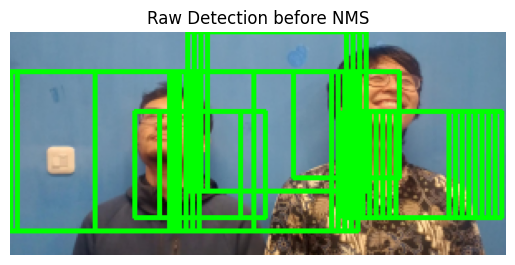

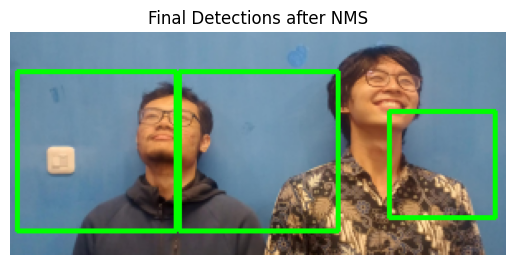

In [428]:
filename = 'path'

image = cv2.imread(filename)
startTop = 0.15
endBottom = 0.9

image = image[int(image.shape[0] * startTop):int(image.shape[0] * endBottom), :]
image = imutils.resize(image, width=min(300, image.shape[1]))

process_image(image, downscale)
process_detected(image, detected, count)
